In [1]:
# display plots in this notebook
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# set display defaults
plt.rcParams['figure.figsize'] = (2, 2) 
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import numpy as np
from PIL import Image

import sys
caffe_root = '/home/haonans/software/caffe-video_triplet/'
sys.path.insert(0, caffe_root + 'python')

import caffe

caffe.set_mode_gpu()

In [122]:
model_def = '/home/haonans/software/caffe-video_triplet/rank_scripts/rank_alexnet/unsup_net_deploy.prototxt'
model_weights = '/home/haonans/capstone/video_models/unsup_alexnet/video_margin_05_iter_50000.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

# set the size of the input (we can skip this if we're happy
# with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

In [123]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]

def get_fc7_vector(image_obj):
#     image_obj = caffe.io.load_image(image_fname)
    
    transformed_image = transformer.preprocess('data', image_obj)
    
    net.blobs['data'].data[...] = transformed_image
    output = net.forward()
    fc7_vector = output['fc7'][0]
    
    return np.array(fc7_vector)

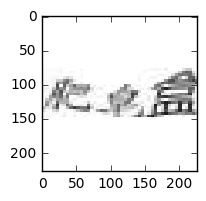

In [124]:
img1 = caffe.io.load_image('/home/haonans/capstone/data/testing/1.jpg')
plt.imshow(img1)

In [125]:
import os

test_fnames = map(lambda fname: os.path.join('/home/haonans/capstone/data/testing/', fname), 
                 os.listdir('/home/haonans/capstone/data/testing/')[:50])

# for i, img_fname in enumerate(test_fnames):
#     img = caffe.io.load_image(img_fname)
#     plt.figure(i)
#     plt.imshow(img)
#     plt.title(i)

In [126]:
img_fnames = [test_fnames[0], test_fnames[1], test_fnames[12], test_fnames[15], test_fnames[40], test_fnames[41], test_fnames[24], test_fnames[27]]

# for i, img_fname in enumerate(img_fnames):
#     img = caffe.io.load_image(img_fname)
#     plt.figure(i)
#     plt.imshow(img)
#     plt.title(i)

vectors = map(lambda f: get_fc7_vector(caffe.io.load_image(f)), img_fnames)

In [127]:
sim_matrix = np.zeros((8,8), dtype=np.float32)

import itertools
for i, j in itertools.product(xrange(8), xrange(8)):
    sim_matrix[i][j] = cosine(vectors[i], vectors[j])

In [128]:
sim_matrix.argmin(axis=1)

array([0, 0, 2, 3, 4, 5, 6, 7])

In [131]:
from pandas import DataFrame
DataFrame(1 - sim_matrix)

,0,1,2,3,4,5,6,7
0,1.000000,1.000000,0.005191,0.099367,0.205768,0.218539,0.310235,0.349042
1,1.000000,1.000000,0.005191,0.099367,0.205768,0.218539,0.310235,0.349042
2,0.005191,0.005191,1.000000,0.875885,0.021961,0.019927,0.698242,0.711670
3,0.099367,0.099367,0.875885,1.000000,0.360745,0.341811,0.675701,0.704466
4,0.205768,0.205768,0.021961,0.360745,1.000000,0.885499,0.173278,0.183506
5,0.218539,0.218539,0.019927,0.341811,0.885499,1.000000,0.233830,0.233663
6,0.310235,0.310235,0.698242,0.675701,0.173278,0.233830,1.000000,0.981799
7,0.349042,0.349042,0.711670,0.704466,0.183506,0.233663,0.981799,1.000000
